In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")

In [2]:
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.ensemble import RandomForestClassifier

# Preprocessing

In [3]:
data_raw = pd.read_csv("monthlywithmomentum.csv", index_col=0)
y_raw = pd.read_csv("y.csv")

In [4]:
y_raw.head()

,date,TICKER,Y
0,19860331,NOAX,1
1,19860331,ALD,1
2,19860331,AC,1
3,19860331,BU,0
4,19860331,BG,0


In [5]:
data_raw.head()

,PERMNO,date,SHRCD,TICKER,COMNAM,CUSIP,PRC,VOL,RET,CFACPR,...,momentum63,momentum84,momentum105,momentum126,momentum147,momentum168,momentum189,momentum210,momentum231,momentum252
0,10062,19860331,11.0,NOAX,NORTHEAST OHIO AXLE INC,29409K60,-10.250,78.0,-0.012048,0.143,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10062,19860430,11.0,NOAX,NORTHEAST OHIO AXLE INC,29409K60,-13.875,508.0,0.353659,0.143,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10062,19860530,11.0,NOAX,N E O A X INC,29409K60,13.750,335.0,-0.009009,0.143,...,0.342463,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10062,19860630,11.0,NOAX,N E O A X INC,29409K60,15.250,366.0,0.109091,0.143,...,0.473627,0.463078,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10062,19860731,11.0,NOAX,N E O A X INC,29409K60,13.250,547.0,-0.131148,0.143,...,-0.027419,0.343420,0.332871,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# drop na
data_raw = data_raw.dropna()
y_raw = y_raw.loc[data_raw.index]
data_raw.index = range(data_raw.shape[0])
y_raw.index = range(data_raw.shape[0])

In [7]:
if not isinstance(data_raw['date'][0], str):
    data_raw["date"] = data_raw["date"].apply(lambda x: str(x)[:4]+'-'+str(x)[4:6]+'-'+str(x)[6:])
data_raw["dateDT"] = pd.to_datetime(data_raw["date"])

if not isinstance(y_raw['date'][0], str):
    y_raw["date"] = y_raw["date"].apply(lambda x: str(x)[:4]+'-'+str(x)[4:6]+'-'+str(x)[6:])
y_raw["dateDT"] = pd.to_datetime(y_raw["date"])

In [8]:
data_raw = data_raw.sort_values(by=["dateDT", "TICKER"])
data_raw.index = range(data_raw.shape[0])

In [9]:
y_raw = y_raw.sort_values(by=["dateDT", "TICKER"])
y_raw.index = range(y_raw.shape[0])

In [10]:
data_raw["id"] = data_raw.index

In [11]:
# split train, val, test
train_val_split = int(data_raw.shape[0]*0.4)
val_test_split = int(data_raw.shape[0]*0.6)
X_train = data_raw.loc[data_raw["dateDT"] <= data_raw["dateDT"][train_val_split]]
train_cut = X_train.shape[0]
X_val = data_raw.iloc[train_cut:].loc[data_raw["dateDT"] <= data_raw["dateDT"][val_test_split]]
val_cut = train_cut + X_val.shape[0]
X_test = data_raw.iloc[val_cut:]

In [12]:
y_train = y_raw.iloc[:train_cut]
y_val = y_raw.iloc[train_cut:val_cut]
y_test = y_raw.iloc[val_cut:]

In [13]:
feature_all = ['PRC', 'VOL', 'RET']

# add momentum terms
for i in range(1,22):
    feature_all.append("momentum" + str(i))
for i in range(42,253,21):
    feature_all.append("momentum" + str(i))

#feature_all

Use the following

`X_train`, `y_train`

`X_val`, `y_val`

`X_test`, `y_test`

# Descriptive Analysis

In [14]:
y_raw.shape

(411846, 4)

In [15]:
data_raw.shape

(411846, 47)

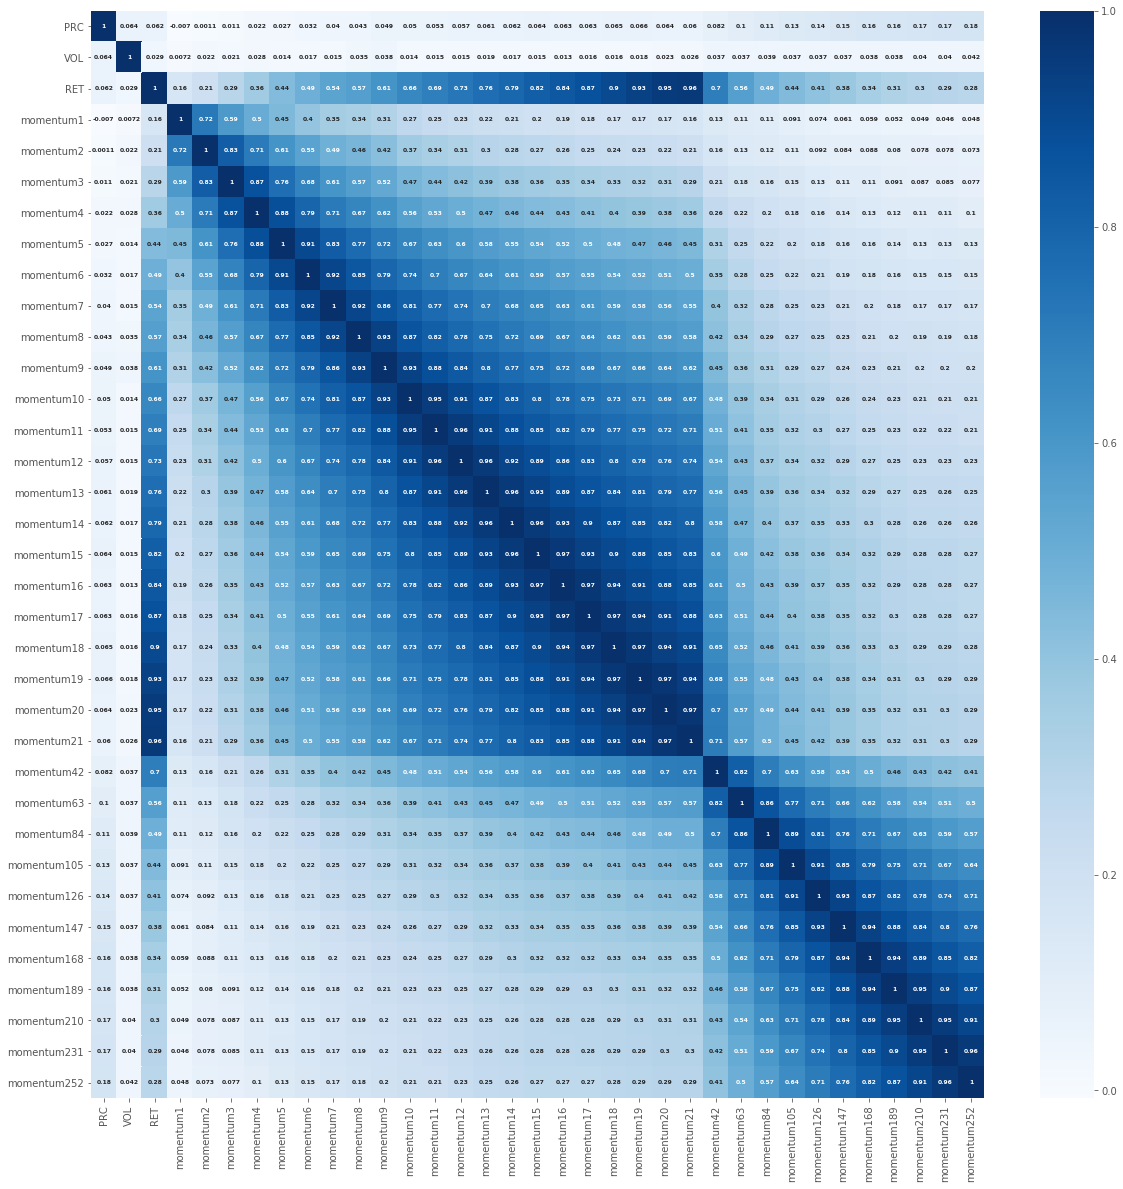

In [16]:
fig = plt.figure(figsize= (20,20))
ax = fig.add_subplot(111)
ax = sns.heatmap(X_train[feature_all].corr(),\
                 annot=True,annot_kws={'size':6,'weight':'bold'},cmap="Blues")

# Basic Models

In [17]:
lasso1 = LassoCV()
lasso1.fit(X_train[feature_all], y_train['Y'])

/Users/zhou/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


LassoCV(alphas=None, copy_X=True, cv='warn', eps=0.001, fit_intercept=True,
        max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

# Compute post prob

In [22]:
date_test = X_test["date"].unique()
ticker_test = X_test["TICKER"].unique()

postprob = pd.DataFrame(columns=ticker_test)
for i in date_test:
    #model.predict_proba(X_test[feature_all])
    postprob.loc[i] = 0
postprob

,AA,ACAS,ACL,ADBE,ADPT,AES,AHAA,AHC,AHP,AIV,...,PRSP,LHX,VAL,BKR,LIN,NLOK,PEAK,J,TFC,VIAC
1999-04-30,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1999-05-28,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1999-06-30,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1999-07-30,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1999-08-31,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1999-09-30,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1999-10-29,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1999-11-30,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1999-12-31,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2000-01-31,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Back test